In [1]:

import os
import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import copy
import pickle


# this directory for the extracted spikes and lfp dictionaries
working_directory = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_lfp_spikes"

# second directory/recording where the rest of analysis will be stored
output_directory = r"D:\MEA_DATA_Aachen\ANALYZED\ID046_lfp_spikes\analysis_trial"




# change to the working_directory
os.chdir(working_directory)



In [2]:

def get_isi_single_channel(spikedic):
    
    '''
    input: 
        spikedic with keys = channellabels, values = spiketimes in raw ticks
    
    
    returns: 

        dictionary with keys = channellabels, values = isi per channel in miliseconds
        
        
    nota bene:
        the amount of spikes is not filtered, we still need to factor out non relevant channels
    
    '''
    
    # set the empty dictionary and temporary list
    isi_dictionary = {}
    isi_temp_list =[]
    
    
    for key in spikedic:
        isi_temp_list =[]
        spikes = spikedic[key]
        spikes = [spike * tick * scale_factor_for_milisecond for spike in spikes]
        
        if len(spikes) >= 2:
            for i in range(0, len(spikes)-1): 

                # calculate the isi
                isi =  spikes[i+1] - spikes[i] 
                isi_temp_list.append(isi)

        isi_dictionary[key] = isi_temp_list
        
    
    return isi_dictionary


def gaussian_smoothing(y, window_size=10, sigma=2):

    filt = signal.gaussian(window_size, sigma)

    return signal.convolve(y, filt, mode='full')





def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert




In [3]:

# for reutlingen files: manually correct the filename, medium, recording date
# cave: the filename is essential to only grab the correct folders later
filename= '2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1'
medium = 'aCSF'
recordingdate = '2021-05-07'


# for aachen files: write loop to get the above info automatically
'''
TO DO WRITE AACHEN LOOP
'''


# now a data structure is created where we can store all necessary information
# i.e., it is a dicionary of dictionaries that will be pickled

Basics = {}
Infos_Recording = {}
Infos_Analysis = {}
Infos_Anatomy = {}
main_recording_dictionary ={}


Infos_Recording['medium']=medium


# the folderlist will contain all 120second long subfolders
# the filename is 
folderlist = glob.glob(filename+'*')




# get into every folder and find the dictionaries
# replace them in a two meta-dictionaries (infodics and spikedics)
infodics = {}
spikedics = {}


In [4]:

for folder in folderlist:
    os.chdir(os.path.join(working_directory, folder))
    timekey = folder.split('_')[9:12]
    timekey = '_'.join(timekey)
    
    # load the info_dic_file
    info_dic_filename = glob.glob('*info*npy')
    print(info_dic_filename)
    print(os.getcwd())
    info_dic = np.load(info_dic_filename[0], allow_pickle=True).item()
    infodics[timekey] = info_dic
    
    # load the spikedic_file
    spike_dic_filename = glob.glob('*spikes_MAD*')[0]
    spikedic_MAD = np.load(spike_dic_filename, allow_pickle=True).item()
    spikedics[timekey] = spikedic_MAD


# separately save all infodics
np.save(os.path.join(output_directory, 'infodics_'+filename+'.npy'), infodics)

# get the first of all infodics
first_info_dic_key = list(infodics.keys())[0]
infodic = infodics[first_info_dic_key]

['2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1__.h5_0_120_info_dict.npy']
D:\MEA_DATA_Aachen\ANALYZED\ID046_lfp_spikes\2021-05-17_cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_from_0_to_120_analyzed_on_21102021


In [5]:

Infos_Recording['info_dics_subrecordings'] = infodics
Infos_Recording['recordings_date'] = recordingdate
Infos_Recording['timelengthrecording_s'] = infodic['timelengthrecording_s']


# the parameter infodic is available through our loop
# it contains the information of the last inofdic we loaded
tick = infodic['tick']
first_recording_timepoint = infodic['first_recording_timepoint']
scale_factor_for_second = infodic['scale_factor_for_second']
timelengthrecording_s = infodic['timelengthrecording_s']
time_in_sec = infodic['time_in_sec']

# we attach them in the first level of the Infos_Recording to 
# have faster access to it
Infos_Recording['scale_factor_for_second'] = scale_factor_for_second
Infos_Recording['tick'] = tick




In [6]:

timekeys = list(spikedics.keys())
channelkeys = list(spikedics[timekeys[0]].keys())


# we now need to use a double loop to get all dictionary keys and join them into a big full recording dictionary
spikedic_MAD_full = {}
temp_spikelist = []

for i in channelkeys:
    temp_spikelist = []
    for j in timekeys:
        spikes = list(spikedics[j][i])
        temp_spikelist.append(spikes)
    
    #join the lists
    temp_spikelista = sum(temp_spikelist, [])
    #remove the duplicates
    temp_spikelistb = list(set(temp_spikelista))
    
    #sort the list
    temp_spikelistc = sorted(temp_spikelistb)
    
    #assign them to their channel in the full dictionary
    spikedic_MAD_full[i] = temp_spikelistc


# join the spikedic to the main_recording dictionary
spikedic_MAD = spikedic_MAD_full
main_recording_dictionary['spikedic_MAD'] = spikedic_MAD

# and save it separately
np.save(os.path.join(output_directory, filename +'_full_spikedic.npy'), spikedic_MAD_full)


# relevant factor: minimal amount of spikes to be relevant
# create an array of the spikes in scale of seconds
active_channels = 0
spikedic_seconds = {}
for key in spikedic_MAD:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_MAD[key])>relevant_factor:
        sec_array = np.asarray(spikedic_MAD[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

# add them to the sub dictionaries
Basics['active_channels'] = active_channels
Basics['relevant_factor'] = relevant_factor


# get a 1-D array with every detected spike
scale_factor_for_milisecond = 1e-03
full_spike_list = []
full_spike_list_seconds = []
for key in spikedic_MAD:
    if len(spikedic_MAD[key])>relevant_factor:
        x = list(np.asarray(spikedic_MAD[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_MAD[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
full_spikes = sorted(full_spike_list)
full_spikes_seconds = sorted(full_spike_list_seconds)


# calculate the mean firing rate for the whole recording
mean_fr_whole_recording = np.around(
    (len(full_spikes_seconds) / timelengthrecording_s), 3)

# add them to the sub dictionaries
Basics['mean_fr_whole_recording'] = mean_fr_whole_recording


C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [7]:
%matplotlib notebook


In [8]:
spikearray_seconds

array([array([ 17.57872,  58.14472,  62.54652,  62.54744,  62.552  ,  62.84872,
               76.44824,  87.25644,  90.36084,  90.36412,  90.37516,  90.39164,
              106.60356, 106.60752, 106.62012, 106.6302 , 113.36064, 113.36112,
              113.36972, 113.3706 , 113.37556, 118.992  , 118.99276, 118.99856]),
       array([ 62.5464 ,  62.54748,  62.84884, 113.36028, 113.36108, 113.36956,
              113.37052, 113.37504, 118.99204, 118.99272])                     ,
       array([ 62.54648,  62.54744,  62.84884,  76.44784, 113.36032, 113.36108,
              113.36972, 113.37056, 113.37452, 118.9916 , 118.99272])          ,
       array([ 62.5464 ,  62.54748,  62.55232,  62.8488 ,  62.84964,  63.44876,
               76.448  ,  87.25652,  90.33176,  90.34516,  90.35156,  90.35428,
               90.35916,  90.36308,  90.36544,  90.37072,  90.37472,  90.37972,
               90.38444,  90.39052,  90.392  ,  90.40056,  90.41052,  90.49644,
               90.49912,  90.5018 , 

In [9]:

#define bins 
binsize = 0.005 #seconds
bins= np.arange(0, timelengthrecording_s+binsize, binsize)

# make a histogram 
full_spikes_binned = np.histogram(full_spikes_seconds, bins)[0]


#trial of population burst plot as inspired by Andrea Corna
bins = int(timelengthrecording_s / binsize)+1

#conversion to hertz
firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
firing_rate = firing_rate_histogram[0]*200 


In [10]:
bins

24080

In [11]:
len(firing_rate_histogram[1])

24081

In [12]:
firing_rate

array([ 400,  600, 1800, ...,  800,    0,  600], dtype=int64)

In [14]:

# sliding window of the moving average
N = int(1/binsize) 

# gaussian smmothing fo the firing rate and moving average
fr_gau = gaussian_smoothing(firing_rate)


ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='full')

# we look for the mean of the MA as threshold
# we arrange this mean in an array for plotting
mean_ma_fr_gau = np.mean(ma_fr_gau)
std_ma_fr_gau = np.std(ma_fr_gau)
network_burst_threshold = mean_ma_fr_gau #+ 1*std_ma_fr_gau
shape_for_threshold = np.shape(ma_fr_gau)
network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)

# extraction of the network bursting activity
# now we identify the burts from the network and will extract an array with 
# tuples containing the burst start and end times
bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []



In [15]:
# this here is the right one!!!

bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []
for index in range(0, len(ma_fr_gau[:-N])):
    if ma_fr_gau[index+N] > network_burst_threshold:
        if ma_fr_gau[index+N-1] <= network_burst_threshold:
            burst_start.append(index)
        if index == 0:
            burst_start.append(0)
            #burst_seconds_start.append((index+N)*0.005)
    else:
        if (ma_fr_gau[index+N-1] > network_burst_threshold) and (len(burst_start)>0):
            if index+N > len(ma_fr_gau):
                ending = len(ma_fr_gau)
            else: 
                ending = index + N

            burst_end.append(ending)
            #burst_seconds_end.append((ending)*0.005)
bursts = list(zip(burst_start, burst_end))



# now we need to reconvert the bins towards seconds:

for i in burst_start:
    burst_seconds_start.append(firing_rate_histogram[1][i])
for i in burst_end:
    if i >= len(firing_rate_histogram[1]):
        burst_seconds_end.append(firing_rate_histogram[1][-1])
    else:
        burst_seconds_end.append(firing_rate_histogram[1][i])

bursts_seconds = list(zip(burst_seconds_start, burst_seconds_end))
# bursts sind jetzt im 5ms bin 
        

In [16]:
# since we reference the bursts back to the seconds and those have different lengths
# we need to correct for bursts that are overlapping
bursts_seconds_corrected = []

for i in range(0, len(bursts_seconds)-1):
    
    first_b = bursts_seconds[i]
    old_first_start = first_b[0]
    old_first_end = first_b[1]
    
    second_b = bursts_seconds[i+1]
    old_second_start = second_b[0]
    old_second_end = second_b[1]
    
    if old_second_start < old_first_end:
        new_first_stop = old_second_start - 0.1 # we substract one msecond
    
        first_b = (old_first_start, new_first_stop)
    
    bursts_seconds_corrected.append(first_b)
    
bursts_seconds = bursts_seconds_corrected
        

<IPython.core.display.Javascript object>


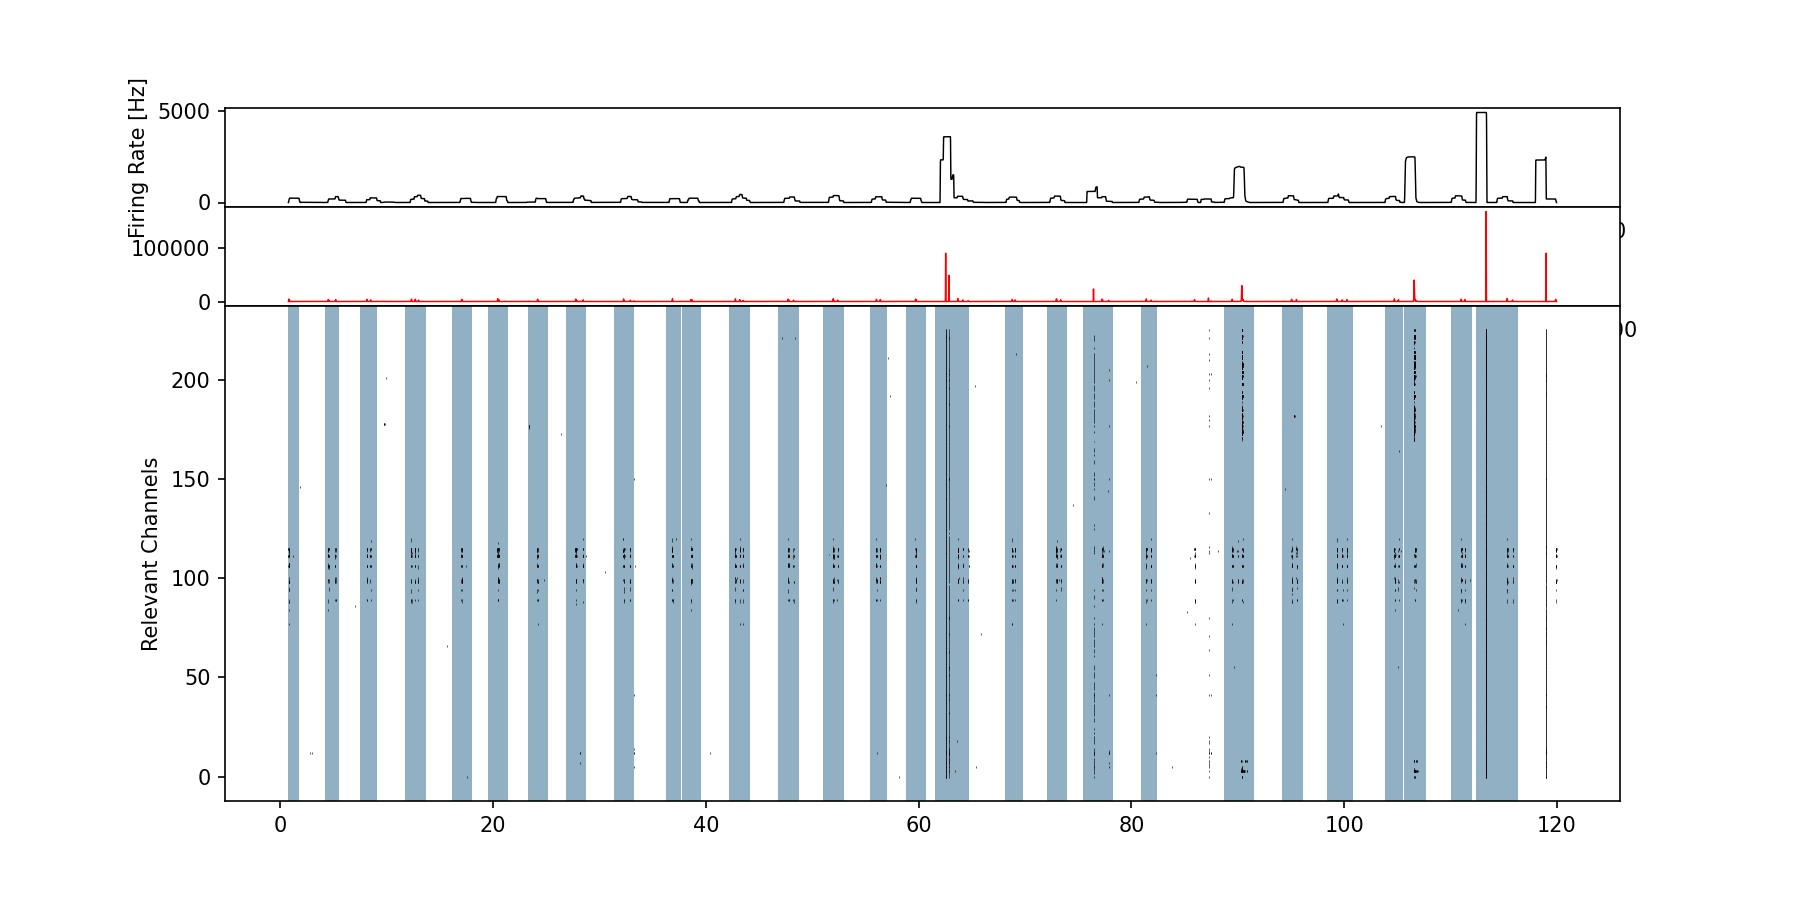

<ipython-input-17-e728b5752f96>:14: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[2].eventplot(spikearray_seconds, color = 'black', linewidths = 0.3,


In [17]:

# add the network bursts to the main_recording_dictionary
main_recording_dictionary['network_bursts_seconds'] = bursts_seconds


# we plot the final rasterplot + firing rate for the whole recording
# for sanity checking
fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(3, hspace = 0, height_ratios=[1,1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black', linewidth = 0.7)

axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].plot(fr_gau, color = 'red', linewidth = 0.7)
axs[2].eventplot(spikearray_seconds, color = 'black', linewidths = 0.3,
                 linelengths = 1, colors = 'black')
axs[2].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[2].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)

In [18]:
active_channels

226

In [19]:
len(time_in_sec)

3000001

In [20]:
conversion_factor = 120 / len(ma_fr_gau)

In [21]:
bursts_seconds

[(0.7632, 1.7830399568106312),
 (4.198971504983389, 5.520802905315615),
 (7.510976024916944, 9.134798868770764),
 (11.694300119601328, 13.664670521594685),
 (16.12020750498339, 18.02621907475083),
 (19.486669498338873, 21.437237182724253),
 (23.249185843853823, 25.160148093023256),
 (26.87308316611296, 28.784045415282392),
 (31.393053460132894, 33.28916367109635),
 (36.24966995348837, 37.63487377408637),
 (37.734873774086374, 39.591378549833884),
 (42.190485235880395, 44.18560903488372),
 (46.824321156146176, 48.75013544352159),
 (51.03239864784053, 53.00276904983389),
 (55.418700598006644, 57.05737548006645),
 (58.81981734717608, 60.71592755813953),
 (61.562493735880395, 64.73587923255815),
 (68.08748918770765, 69.82022697840532),
 (72.03813135049833, 73.98374835548172),
 (75.47390285548173, 78.27103671760797),
 (80.8651927242525, 82.4246567358804),
 (88.6823155, 91.49430140033223),
 (94.13796420099668, 96.10338392358804),
 (98.40544984551495, 100.84613479069768),
 (103.85614786710964

In [282]:
# since we reference the bursts back to the seconds and those have different lengths
# we need to correct for bursts that are overlapping
bursts_seconds_corrected = []

for i in range(0, len(bursts_seconds)-1):
    
    first_b = bursts_seconds[i]
    old_first_start = first_b[0]
    old_first_end = first_b[1]
    
    second_b = bursts_seconds[i+1]
    old_second_start = second_b[0]
    old_second_end = second_b[1]
    
    if old_second_start < old_first_end:
        new_first_stop = old_second_start - 0.1 # we substract one msecond
    
        first_b = (old_first_start, new_first_stop)
    
    bursts_seconds_corrected.append(first_b)
        
    

In [283]:
bursts_seconds = bursts_seconds_corrected